In [11]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial

import piml_library.lagrangian as lgr
import piml_library.util as util
import piml_library.dataset_generator as dg
import piml_library.plotting as plotting
from piml_library.bnn import (
    BaselineNN, 
    compute_loss, 
    train_step, 
    create_trajectory,
)

In [12]:
@jax.jit
def L_analytical(state):
    q = lgr.coordinate(state)
    v = lgr.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [13]:
@jax.jit
def H_analytical(state, m=1.0, k=1.0):
    q = lgr.coordinate(state) 
    v = lgr.velocity(state) 
    
    q_flat, _ = ravel_pytree(q) 
    v_flat, _ = ravel_pytree(v) 
    
    T = 0.5 * m * jnp.sum(v_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [14]:
q_dim = 1
hidden_dim = 128
learning_rate = 1e-3
num_epochs = 5000
key = jax.random.PRNGKey(0)

num_trajectories = 50
N_points_per_traj = 500
t_end = 25.0
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)

split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)

--- 学習用・テスト用データセットの生成開始 ---
Generating 50 trajectories...
--- データセット生成完了 ---
Total Train Points: 12500
Total Test Points:  12500


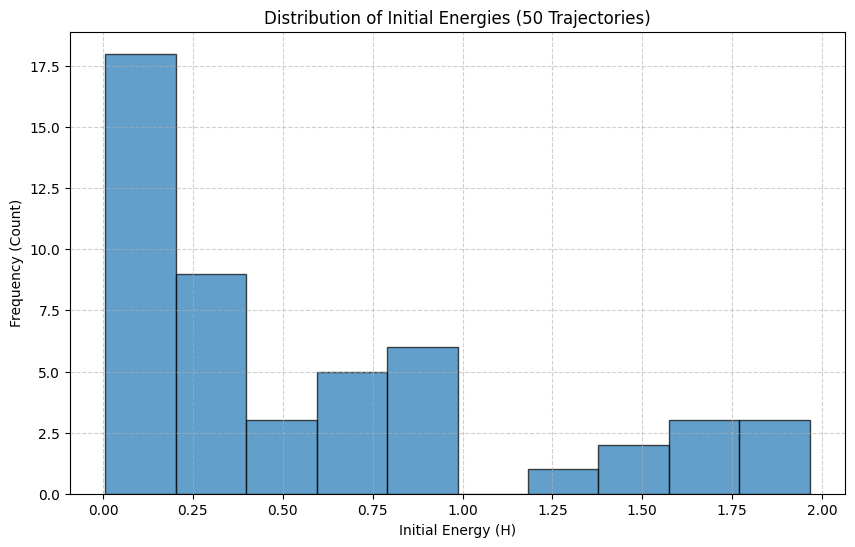

In [15]:
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states"]
train_t, train_q, train_v = train_states
train_targets = data_dict["train_targets"]
test_dataset_states = data_dict["test_dataset_states"]
test_dataset_true_accel = data_dict["test_dataset_true_accel"]
initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

# --- エネルギー分布の可視化 ---
energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [16]:
'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
bnn_model = BaselineNN(hidden_dim=hidden_dim)
model_apply_fn = bnn_model.apply  # jitで使用できるようにするためapplyというメソッドを変数に割り当てる。

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_v = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_v)

params = bnn_model.init(init_key, dummy_state)['params'] #構造を決定
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリ状態

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

# ミニバッチのサイズ
batch_size = 256 

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    t_batch = train_t[indices]
    q_batch = train_q[indices]
    v_batch = train_v[indices]
    
    batch_states = (t_batch, q_batch, v_batch)
    batch_true_accel = train_targets[indices]
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        batch_states, 
        batch_true_accel
    )
    
    if epoch % 500 == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_true_accel
        )
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("学習完了。")

# Final Test Loss
final_test_loss = compute_loss(params, model_apply_fn, test_dataset_states, test_dataset_true_accel)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 2.220097, Test Loss: 1.203950
Epoch 500, Train Loss: 0.530797, Test Loss: 0.611107
Epoch 1000, Train Loss: 0.654790, Test Loss: 0.593145
Epoch 1500, Train Loss: 0.462585, Test Loss: 0.585507
Epoch 2000, Train Loss: 0.549759, Test Loss: 0.592469
Epoch 2500, Train Loss: 0.597405, Test Loss: 0.585211
Epoch 3000, Train Loss: 0.580544, Test Loss: 0.587686
Epoch 3500, Train Loss: 0.582561, Test Loss: 0.585081
Epoch 4000, Train Loss: 0.687844, Test Loss: 0.585158
Epoch 4500, Train Loss: 0.535781, Test Loss: 0.585521
学習完了。
--- Final Test Loss: 0.585237 ---
--- Total Training Time: 48.90 seconds ---


In [29]:
'''
generate trajectory
'''

# 予測と挙動の比較
print("軌道を生成して、真の挙動と比較します...")
solver_learned = create_trajectory(model_apply_fn, params)

ds_true = lgr.state_derivative(L_analytical)
solver_true = util.ode_solver(ds_true)

# Initial state (t=0, q=1.0, v=0.0)
initial_state = (0.0, jnp.array([1.0]), jnp.array([0.0]))
t_eval = jnp.linspace(0.0, 50.0, 1000)

learned_trajectory = solver_learned(initial_state, t_eval) #ode_solverに初期位置が渡され時間発展が計算される

start_inference_time = time.time()
learned_trajectory[1].block_until_ready() 
end_inference_time = time.time()
print(f"--- Trajectory Inference Time: {end_inference_time - start_inference_time:.4f} seconds ---")

true_trajectory = solver_true(initial_state, t_eval)
print("軌道生成が完了しました。")

軌道を生成して、真の挙動と比較します...
--- Trajectory Inference Time: 0.0014 seconds ---
軌道生成が完了しました。


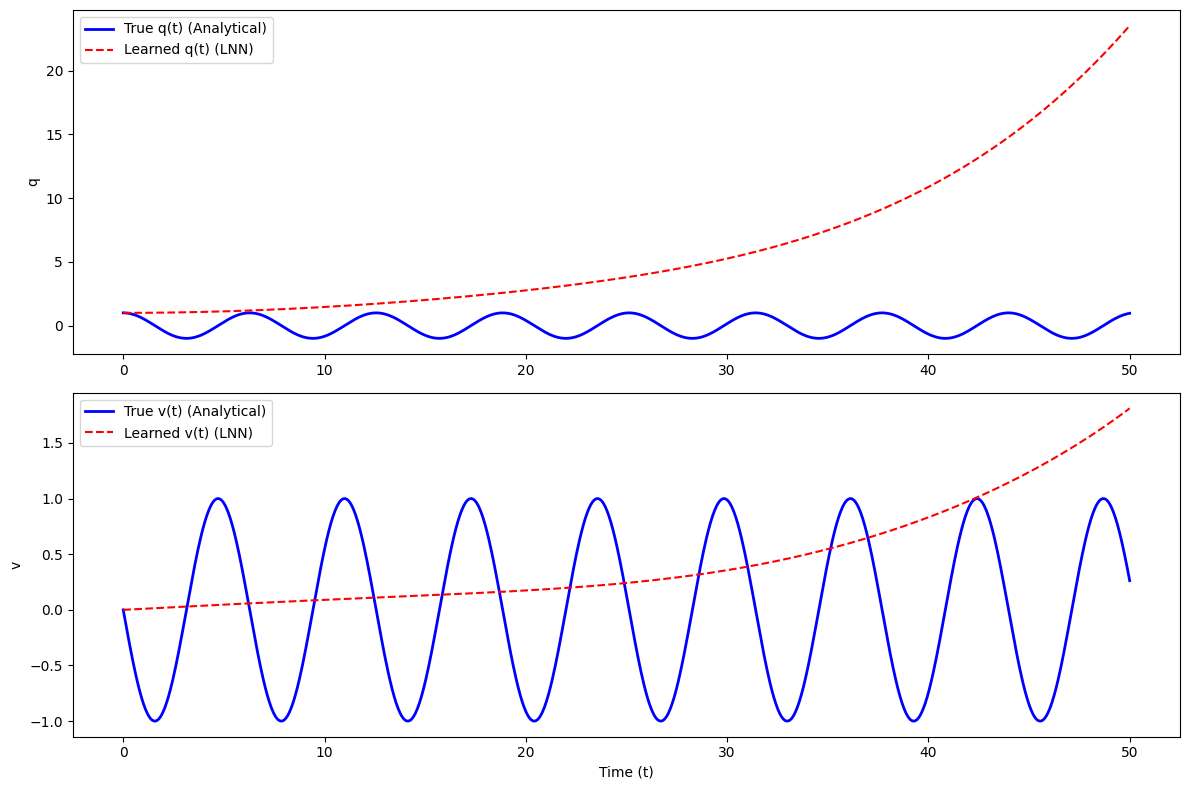

In [30]:
''' 
plot result
'''
# 軌道は (t, q, v) のタプルで返ってくる
t_learned, q_learned, v_learned = learned_trajectory 
t_true, q_true, v_true = true_trajectory 
plt.figure(figsize=(12, 8)) #
    
# 座標q の比較
plt.subplot(2, 1, 1) #
plt.plot(t_true, q_true, 'b-', label='True q(t) (Analytical)', linewidth=2) #
plt.plot(t_learned, q_learned, 'r--', label='Learned q(t) (LNN)', markersize=4) #
plt.ylabel('q') #
plt.legend() #

# 速度v の比較
plt.subplot(2, 1, 2) #
plt.plot(t_true, v_true, 'b-', label='True v(t) (Analytical)', linewidth=2) #
plt.plot(t_learned, v_learned, 'r--', label='Learned v(t) (LNN)', markersize=4) #
plt.xlabel('Time (t)') #
plt.ylabel('v') #
plt.legend() #

plt.tight_layout() #
plt.show() #